In [1]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
print(os.listdir("data\ml-marathon-final\kaggle_dogcat"))


Using TensorFlow backend.


['sample_submission.csv', 'test', 'train']


In [2]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [3]:
filenames = os.listdir("data/ml-marathon-final/kaggle_dogcat/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

In [4]:
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [5]:
df.head(10)

,filename,category
0,cat.10001.jpg,0
1,cat.10002.jpg,0
2,cat.10005.jpg,0
3,cat.10008.jpg,0
4,cat.10024.jpg,0
5,cat.10025.jpg,0
6,cat.10029.jpg,0
7,cat.1004.jpg,0
8,cat.10050.jpg,0
9,cat.10053.jpg,0


In [6]:
df.tail(10)

,filename,category
3992,dog.9942.jpg,1
3993,dog.9954.jpg,1
3994,dog.9960.jpg,1
3995,dog.997.jpg,1
3996,dog.9972.jpg,1
3997,dog.9974.jpg,1
3998,dog.9979.jpg,1
3999,dog.9982.jpg,1
4000,dog.9985.jpg,1
4001,dogs,0


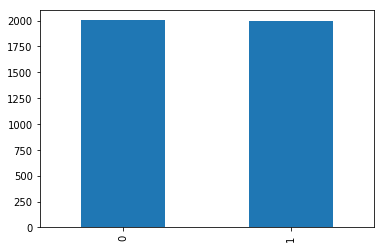

In [7]:
df['category'].value_counts().plot.bar()

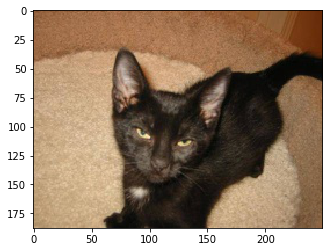

In [8]:
sample = random.choice(filenames)
image = load_img("data/ml-marathon-final/kaggle_dogcat/train/"+sample)
    
plt.imshow(image) 

In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

W0812 21:35:06.833624 19660 deprecation_wrapper.py:119] From C:\Users\jerry\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0812 21:35:06.853530 19660 deprecation_wrapper.py:119] From C:\Users\jerry\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0812 21:35:06.855524 19660 deprecation_wrapper.py:119] From C:\Users\jerry\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0812 21:35:06.881488 19660 deprecation_wrapper.py:119] From C:\Users\jerry\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0812 21:35:06.882483 19660 deprecation_wrapper.py:119] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
__________

In [10]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [11]:
earlystop = EarlyStopping(patience=10)

In [12]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [13]:
callbacks = [earlystop, learning_rate_reduction]

In [14]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [15]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

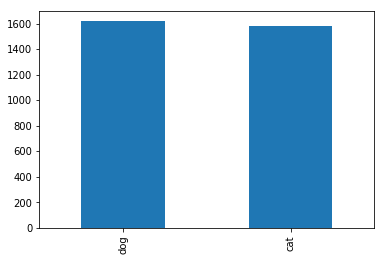

In [16]:
train_df['category'].value_counts().plot.bar()

In [17]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [18]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "data/ml-marathon-final/kaggle_dogcat/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 3199 validated image filenames belonging to 2 classes.


C:\Users\jerry\Anaconda3\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 2 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [19]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "data/ml-marathon-final/kaggle_dogcat/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 801 validated image filenames belonging to 2 classes.


In [20]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "data/ml-marathon-final/kaggle_dogcat/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


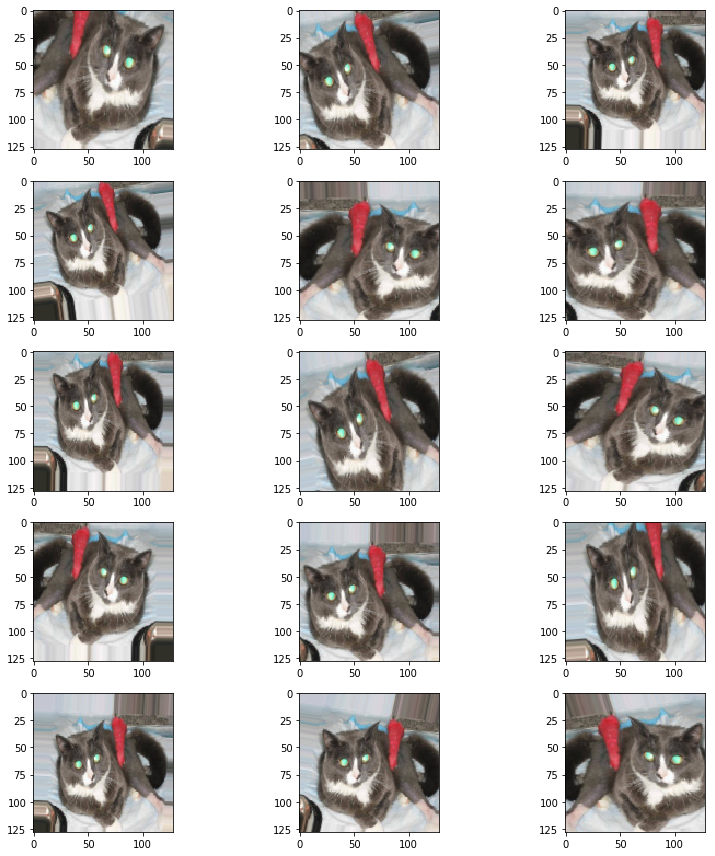

In [21]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [22]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

W0812 21:38:43.259826 19660 deprecation.py:323] From C:\Users\jerry\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
213/213 [==============================] - 204s 958ms/step - loss: 1.2024 - acc: 0.5559 - val_loss: 0.8430 - val_acc: 0.6302
Epoch 2/50
213/213 [==============================] - 183s 858ms/step - loss: 0.7896 - acc: 0.6049 - val_loss: 1.0887 - val_acc: 0.5051
Epoch 3/50
213/213 [==============================] - 182s 856ms/step - loss: 0.7040 - acc: 0.6183 - val_loss: 0.6982 - val_acc: 0.6285

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/50
213/213 [==============================] - 182s 854ms/step - loss: 0.6150 - acc: 0.6632 - val_loss: 0.5686 - val_acc: 0.7048
Epoch 5/50
213/213 [==============================] - 182s 855ms/step - loss: 0.5983 - acc: 0.6818 - val_loss: 0.5680 - val_acc: 0.6896
Epoch 6/50
213/213 [==============================] - 182s 857ms/step - loss: 0.5697 - acc: 0.7009 - val_loss: 0.5490 - val_acc: 0.7226
Epoch 7/50
213/213 [==============================] - 183s 860ms/step - loss: 0.5521 - acc: 0.7268 - va

In [23]:
model.save_weights("model.h5")

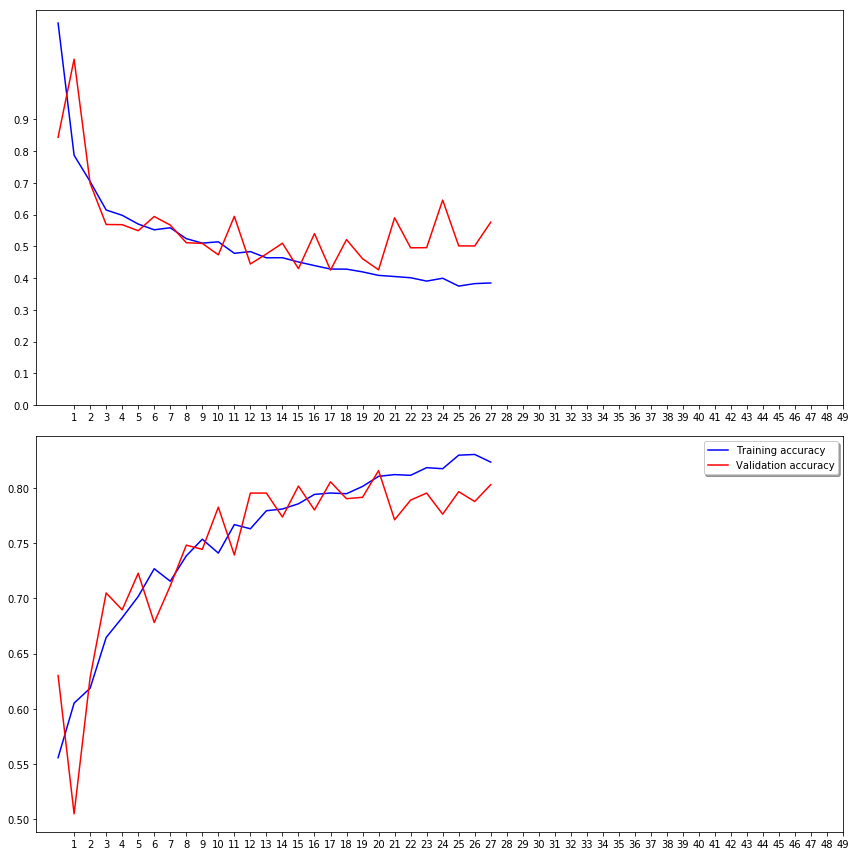

In [24]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [25]:
test_filenames = os.listdir("data/ml-marathon-final/kaggle_dogcat/test")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [26]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "data/ml-marathon-final/kaggle_dogcat/test/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 400 validated image filenames.


In [27]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [28]:
test_df['category'] = np.argmax(predict, axis=-1)

In [29]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [30]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

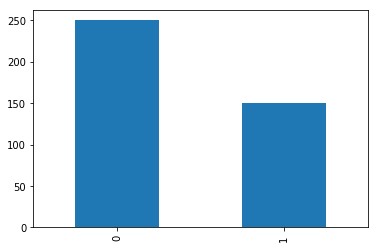

In [31]:
test_df['category'].value_counts().plot.bar()

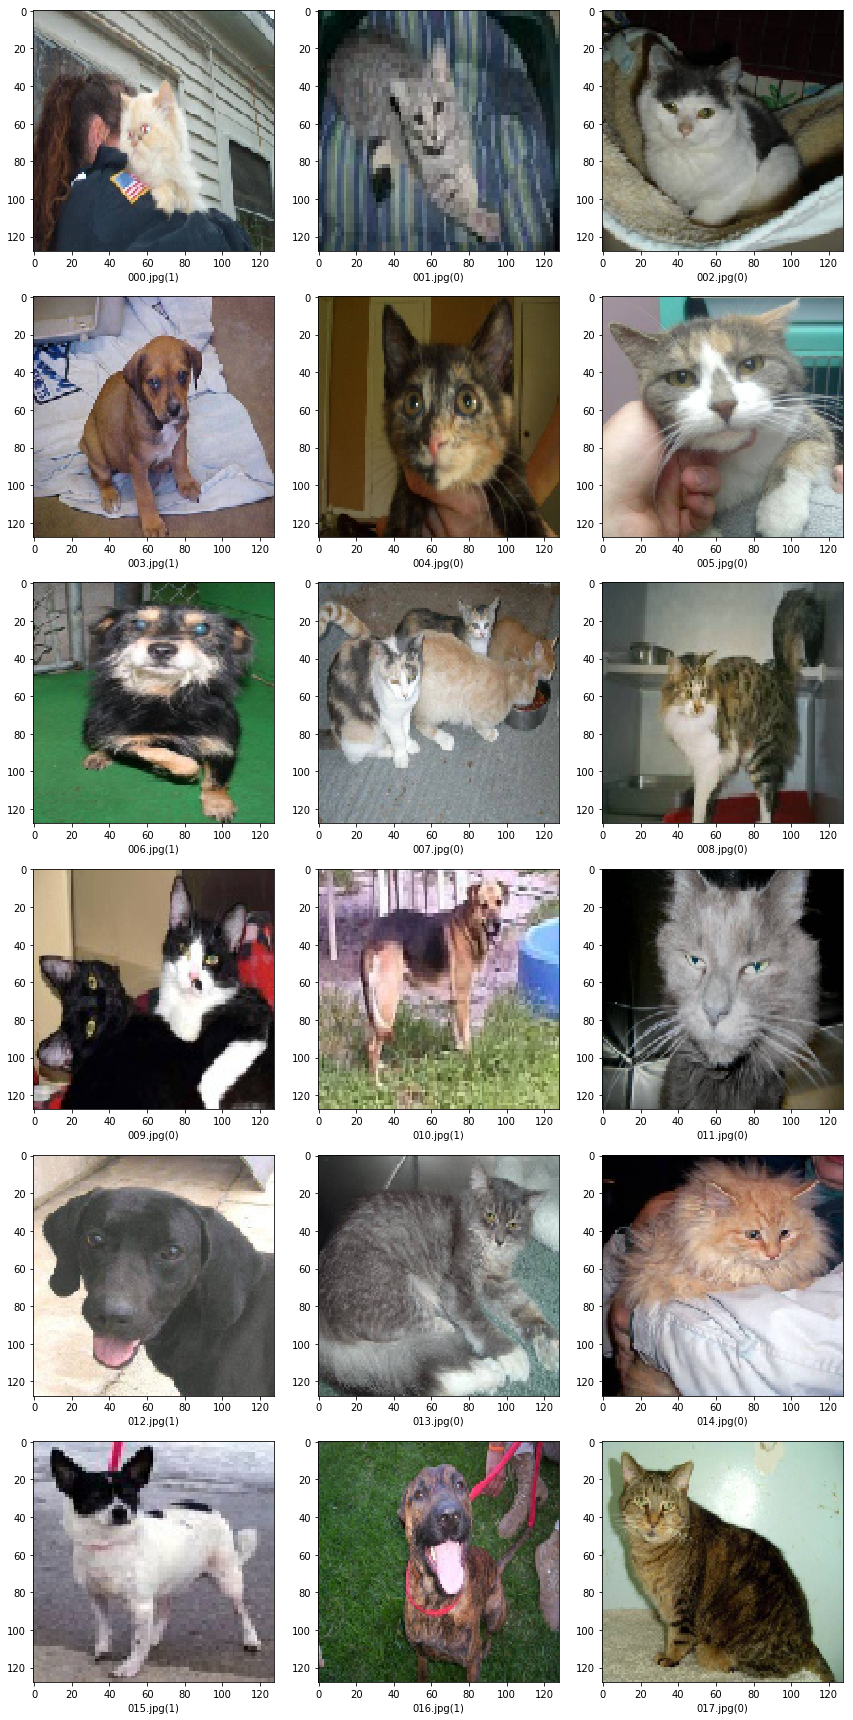

In [32]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("data/ml-marathon-final/kaggle_dogcat/test/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [34]:
submission_df = test_df.copy()
submission_df['ID'] = submission_df['filename'].str.split('.').str[0]
submission_df['Predicted'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)